### Hyperparameter Definition

In [1]:
train_data_path = '/kaggle/input/omniglot/images_background/'
test_data_path = '/kaggle/input/omniglot/images_evaluation/'
# n_way = 5
n_way = 20
k_shot = 1
q_query = 5
outer_lr = 0.001
inner_lr = 0.04
meta_batch_size = 32
train_inner_step = 1
eval_inner_step = 3
num_iterations = 250
# num_iterations = 500
num_workers = 0
valid_size = 0.2
random_seed = 42
display_gap = 50

### Library Importation & Random Seed Setting

In [2]:
import os
import glob
import torch
import random
import collections
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
from torchvision.transforms import transforms
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
def generate_pseudo_labels(classifier, unlabeled_data, threshold=0.8):
    classifier.eval()
    with torch.no_grad():
        # Generate predictions for unlabeled data
        logits = classifier(unlabeled_data)
        probs = F.softmax(logits, dim=1)  # Probabilities for each class
        
        # Get the predicted class and confidence
        pseudo_labels = torch.argmax(probs, dim=1).cpu().numpy()
        high_confidence = (torch.max(probs, dim=1).values > threshold).cpu().numpy()
    
    return pseudo_labels, high_confidence

### Dataset Definition

In [4]:
class MAMLDataset(Dataset):
    # here 'task_num' is the batch size of each meta learning iteration
    # "n_way" is the number of classes to be classified
    # "k_shot" is the number of data samples of each class used for training (support)
    # "q_query" is the number of data samples of each class used for testing (query)
    # "k_shot" is set to be equal to "q_query" by default
    def __init__(self, data_path, n_way=5, k_shot=1, q_query=1):

        self.file_list = self.get_file_list(data_path)
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query

    def get_file_list(self, data_path):
        raise NotImplementedError('get_file_list function not implemented!')

    def get_one_task_data(self):
        raise NotImplementedError('get_one_task_data function not implemented!')

    def __len__(self):
        # This number does not influence the results,
        # since we will randomly sample task 
        # from the entire class dataset each time,
        # which means that the size of it can be seen as Infinity.
        # And as the setting below, any number here wont influence the result.
        return len(self.file_list)

    def __getitem__(self, index):
        return self.get_one_task_data()

class OmniglotDataset(MAMLDataset):
    def get_file_list(self, data_path):
        """
        Get a list of all classes.
        Args:
            data_path: Omniglot Data path

        Returns: list of all classes

        """
        return [f for f in glob.glob(data_path + "**/character*", recursive=True)]

    def get_one_task_data(self):
        """
        Get ones task maml data, include one batch support images and labels, one batch query images and labels.
        Returns: support_data, query_data

        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_image = []
        support_label = []
        query_image = []
        query_label = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob.glob(img_dir + "**/*.png", recursive=True)]
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = transforms.Resize(size=28)(Image.open(img_path))
                image = np.array(image)
                image = np.expand_dims(image / 255., axis=0)
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = transforms.Resize(size=28)(Image.open(img_path))
                image = np.array(image)
                image = np.expand_dims(image / 255., axis=0)
                query_data.append((image, label))

        # shuffle support set
        random.shuffle(support_data)
        for data in support_data:
            support_image.append(data[0])
            support_label.append(data[1])

        # shuffle query set
        random.shuffle(query_data)
        for data in query_data:
            query_image.append(data[0])
            query_label.append(data[1])

        # query_label = np.array(query_label)

        # # Now apply pseudo-labeling for unlabeled data (query set)
        # query_tensor = torch.tensor(query_image).float()
        
        # # Generate pseudo-labels for unlabeled data in the query set
        # pseudo_labels, high_confidence = generate_pseudo_labels(self.classifier, query_tensor)

        # # Update labels for high-confidence pseudo-labeled samples
        # query_label[high_confidence] = pseudo_labels[high_confidence]

        return np.array(support_image), np.array(support_label), np.array(query_image), np.array(query_label)


class OmniglotDatasetTrain(MAMLDataset):
    def __init__(self, data_path, n_way=5, k_shot=1, q_query=1, classifier=None):
        super().__init__(data_path, n_way, k_shot, q_query)
        self.classifier = classifier
    def get_file_list(self, data_path):
        """
        Get a list of all classes.
        Args:
            data_path: Omniglot Data path

        Returns: list of all classes

        """
        return [f for f in glob.glob(data_path + "**/character*", recursive=True)]
        
    def get_one_task_data(self):
        """
        Generate one MAML task, include one batch of support images and labels, one batch of query images and labels.
        """
        img_dirs = random.sample(self.file_list, self.n_way)
        support_data = []
        query_data = []

        support_images = []
        support_labels = []
        query_images = []
        query_labels = []

        for label, img_dir in enumerate(img_dirs):
            img_list = [f for f in glob.glob(img_dir + "**/*.png", recursive=True)]
            images = random.sample(img_list, self.k_shot + self.q_query)

            # Read support set
            for img_path in images[:self.k_shot]:
                image = transforms.Resize(size=28)(Image.open(img_path))
                image = np.array(image)
                image = np.expand_dims(image / 255., axis=0)
                support_data.append((image, label))

            # Read query set
            for img_path in images[self.k_shot:]:
                image = transforms.Resize(size=28)(Image.open(img_path))
                image = np.array(image)
                image = np.expand_dims(image / 255., axis=0)
                query_data.append((image, label))

        # shuffle support set
        random.shuffle(support_data)
        for data in support_data:
            support_images.append(data[0])
            support_labels.append(data[1])

        # shuffle query set
        random.shuffle(query_data)
        for data in query_data:
            query_images.append(data[0])
            query_labels.append(data[1])

        # Convert to Tensor (before passing to model)
        support_images = torch.tensor(support_images).float()
        support_labels = torch.tensor(support_labels).long()

        query_images = torch.tensor(query_images).float()
        # query_labels = torch.tensor(query_labels).long()

        # Convert grayscale images (1 channel) to RGB (3 channels)
        query_images_rgb = query_images.repeat(1, 3, 1, 1)  # Replicating grayscale to RGB

        # Now query_images_rgb has the right shape for ResNet (3 channels)
        logits = self.classifier(query_images_rgb)  # Generate pseudo-labels using ResNet

        # Generate pseudo-labels based on the model's predictions
        pseudo_labels, high_confidence = generate_pseudo_labels(self.classifier, query_images_rgb)

        query_labels = np.array(query_labels)
        pseudo_labels = np.array(pseudo_labels)

        # Use the high-confidence pseudo-labels to update query_labels
        query_labels[high_confidence] = pseudo_labels[high_confidence]

        return np.array(support_images), np.array(support_labels), np.array(query_images), np.array(query_labels)

    # def get_one_task_data(self):
    #     """
    #     Get ones task maml data, include one batch support images and labels, one batch query images and labels.
    #     Returns: support_data, query_data

    #     """
    #     img_dirs = random.sample(self.file_list, self.n_way)
    #     support_data = []
    #     query_data = []

    #     support_image = []
    #     support_label = []
    #     query_image = []
    #     query_label = []

    #     for label, img_dir in enumerate(img_dirs):
    #         img_list = [f for f in glob.glob(img_dir + "**/*.png", recursive=True)]
    #         images = random.sample(img_list, self.k_shot + self.q_query)

    #         # Read support set
    #         for img_path in images[:self.k_shot]:
    #             image = transforms.Resize(size=28)(Image.open(img_path))
    #             image = np.array(image)
    #             image = np.expand_dims(image / 255., axis=0)
    #             support_data.append((image, label))

    #         # Read query set
    #         for img_path in images[self.k_shot:]:
    #             image = transforms.Resize(size=28)(Image.open(img_path))
    #             image = np.array(image)
    #             image = np.expand_dims(image / 255., axis=0)
    #             query_data.append((image, label))

    #     # shuffle support set
    #     random.shuffle(support_data)
    #     for data in support_data:
    #         support_image.append(data[0])
    #         support_label.append(data[1])

    #     # shuffle query set
    #     random.shuffle(query_data)
    #     for data in query_data:
    #         query_image.append(data[0])
    #         query_label.append(data[1])

    #     query_label = np.array(query_label)

    #     # Now apply pseudo-labeling for unlabeled data (query set)
    #     query_tensor = torch.tensor(query_image).float()
        
    #     # Generate pseudo-labels for unlabeled data in the query set
    #     pseudo_labels, high_confidence = generate_pseudo_labels(self.classifier, query_tensor)

    #     # Update labels for high-confidence pseudo-labeled samples
    #     query_label[high_confidence] = pseudo_labels[high_confidence]

    #     return np.array(support_image), np.array(support_label), np.array(query_image), query_label

### Classifier Model Definition

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv2d = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv2d(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.max_pool(x)
        return x


def ConvBlockFunction(input, w, b, w_bn, b_bn):
    x = F.conv2d(input, w, b, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=w_bn, bias=b_bn, training=True)
    x = F.relu(x)
    output = F.max_pool2d(x, kernel_size=2, stride=2)

    return output


class Classifier(nn.Module):
    def __init__(self, in_ch, n_way):
        super(Classifier, self).__init__()
        self.conv1 = ConvBlock(in_ch, 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = ConvBlock(64, 64)
        self.logits = nn.Linear(64, n_way)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.logits(x)
        return x

    def functional_forward(self, x, params):
        for block in [1, 2, 3, 4]:
            x = ConvBlockFunction(
                x,
                params[f"conv{block}.conv2d.weight"],
                params[f"conv{block}.conv2d.bias"],
                params.get(f"conv{block}.bn.weight"),
                params.get(f"conv{block}.bn.bias"),
            )
        x = x.view(x.shape[0], -1)
        x = F.linear(x, params["logits.weight"], params["logits.bias"])
        return x

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

In [7]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out

In [9]:
def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

# def resnet34(**kwargs):
#     return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

# def resnet50(**kwargs):
#     return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)

# def resnet101(**kwargs):
#     return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)

In [10]:
model_dict = {
    'resnet18': [resnet18, 512],
    # 'resnet34': [resnet34, 512],
    # 'resnet50': [resnet50, 2048],
    # 'resnet101': [resnet101, 2048],
}

In [11]:
class ResNetModel(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128):
        super(ResNetModel, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat

### Helper Functions (1): get dataset & spilt train and valid

In [12]:
def get_dataset(
        train_data_path,
        test_data_path,
        n_way,
        k_shot,
        q_query,
        model
):
    """
    Get maml dataset.
    Args:
        args: ArgumentParser

    Returns: dataset
    """
    train_dataset = OmniglotDatasetTrain(train_data_path, 
                                    n_way, 
                                    k_shot, 
                                    q_query, 
                                    classifier=model)
    
    valid_dataset = OmniglotDatasetTrain(train_data_path, 
                                    n_way, 
                                    k_shot, 
                                    q_query, 
                                    classifier=model)

    test_dataset = OmniglotDataset(test_data_path, 
                                   n_way, 
                                   k_shot, 
                                   q_query, 
                                    )
    
    train_dataset, valid_dataset = spilt_train_valid(train_dataset, 
                                                     valid_dataset, 
                                                     valid_size)

    return train_dataset, valid_dataset, test_dataset


def spilt_train_valid(train_dataset, valid_dataset, valid_set_size):
    """
    Spilt train dataset into train and valid dataset according to the given size.
    Args:
        train_dataset: original train dataset
        valid_dataset: spilted valid dataset to put into
        valid_set_size: given size in terms of proportion
    
    Returns: spilted train and valid datasets
    """
    valid_set_size = int(valid_set_size * len(train_dataset))
    train_set_size = len(train_dataset) - valid_set_size

    file_list = train_dataset.file_list
    random.shuffle(file_list)
    
    train_dataset.file_list = file_list[:train_set_size]
    valid_dataset.file_list = file_list[train_set_size:]

    return train_dataset, valid_dataset

### Helper Function (2): train one meta-batch

In [13]:
def maml_train(model, 
               support_images,
               support_labels,
               query_images,
               query_labels, 
               inner_step, 
               inner_lr,
               optimizer, 
               loss_fn,
               is_train=True):
    """
    Train the model using MAML method.
    Args:
        model: Any model
        support_images: several task support images
        support_labels: several  support labels
        query_images: several query images
        query_labels: several query labels
        inner_step: support data training step
        inner_lr: inner
        optimizer: optimizer
        is_train: whether train

    Returns: meta loss, meta accuracy
    """
    meta_loss = []
    meta_acc = []

    # Get support set and query set data for one train task
    for support_image, support_label, query_image, query_label \
        in zip(support_images, support_labels, query_images, query_labels):

        fast_weights = collections.OrderedDict(model.named_parameters())
        for _ in range(inner_step):
            # Update weight
            # logit: batch_num * n_way * 1
            support_logit = model.functional_forward(support_image, fast_weights)
            support_loss = loss_fn(support_logit, support_label)
            grads = torch.autograd.grad(support_loss, 
                                        fast_weights.values(), 
                                        create_graph=True)
            fast_weights = collections.OrderedDict((name, param - inner_lr * grads)
                                                   for ((name, param), grads) 
                                                   in zip(fast_weights.items(), grads))

        # Use trained weight to get query loss
        query_logit = model.functional_forward(query_image, fast_weights)
        query_prediction = torch.max(query_logit, dim=1)[1]

        query_loss = loss_fn(query_logit, query_label)
        query_acc = torch.eq(query_label, query_prediction).sum() / len(query_label)

        meta_loss.append(query_loss)
        meta_acc.append(query_acc.data.cpu().numpy())

    meta_loss = torch.stack(meta_loss).mean()
    meta_acc = np.mean(meta_acc)

    if is_train:
        optimizer.zero_grad()
        meta_loss.backward()
        optimizer.step()

    return meta_loss, meta_acc

### Loading SSL model

In [14]:
# model = ResNetModel(name='resnet50', head='mlp', feat_dim=128)
ssl_model = ResNetModel(name='resnet18', head='mlp', feat_dim=128)

In [15]:
checkpoint = torch.load('/kaggle/input/resnet-embeddings/resnet_model.pth') 
ssl_model.load_state_dict(checkpoint)

/tmp/ipykernel_23/2793156745.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/resnet-embeddings/resnet_model.pth')


<All keys matched successfully>

### Data Loading

In [16]:
train_tasks, valid_tasks, test_tasks = get_dataset(train_data_path,
                                                   test_data_path,
                                                   n_way,
                                                   k_shot,
                                                   q_query,
                                                   model=ssl_model)

train_loader = DataLoader(train_tasks, batch_size=meta_batch_size, 
                            shuffle=True, drop_last=True,  num_workers=num_workers)

valid_loader = DataLoader(valid_tasks, batch_size=meta_batch_size, 
                            shuffle=True, drop_last=True, num_workers=num_workers)

test_loader = DataLoader(test_tasks, batch_size=meta_batch_size, 
                            shuffle=False, drop_last=True, num_workers=num_workers)

### Model & Optimizer Initialization

In [17]:
model = Classifier(in_ch=1, n_way=n_way)
model.to(device)
optimizer = optim.Adam(model.parameters(), outer_lr)
loss_fn = nn.CrossEntropyLoss().to(device)

### Training ResNet on subset of data

In [18]:
# def save_checkpoint(model, optimizer, epoch, loss, filepath):
#     # Save the model state, optimizer state, and training state
#     checkpoint = {
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss
#     }
#     torch.save(checkpoint, filepath)
#     print(f"Checkpoint saved at {filepath}")

In [19]:
# transform = transforms.Compose([
#     transforms.Resize((28, 28)),  # Resize to a fixed size (optional)
#     transforms.ToTensor(),          # Convert images to PyTorch tensors
#     # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1] (optional)
# ])

# train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)

# portion_size = int(len(train_dataset) * 0.2)
# subset_indices = np.random.choice(len(train_dataset), size=portion_size, replace=False)
# train_subset = Subset(train_dataset, subset_indices)
# np.save('unlabeled_indices.npy', subset_indices)

# train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)

# ssl_model.train()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ssl_model = ssl_model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(ssl_model.parameters(), lr=0.001, momentum=0.9)

# num_epochs = 20
# for epoch in range(num_epochs): 
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     for inputs, labels in train_loader:
#         # Move data to GPU if available
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = ssl_model(inputs)

#         # Calculate the loss
#         loss = criterion(outputs, labels)

#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Print statistics (for monitoring)
#         running_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)

#         # Update the number of correct predictions
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         # Print statistics
#         running_loss += loss.item()

#     # Calculate and print accuracy

#         torch.cuda.empty_cache()

#     accuracy = 100 * correct / total
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}")
#     save_checkpoint(ssl_model, optimizer, epoch, running_loss/len(train_loader), 'checkpoint.pth')

In [20]:
# model_save_path = "resnet_model.pth"
# torch.save(ssl_model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

### MAML Training & Testing

/tmp/ipykernel_23/12788558.py:161: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  support_images = torch.tensor(support_images).float()


======================== Iteration: 1 ========================
Meta Train Loss: 2.905, Meta Train Acc: 10.94%
Meta Valid Loss: 2.833, Meta Valid Acc: 14.88%


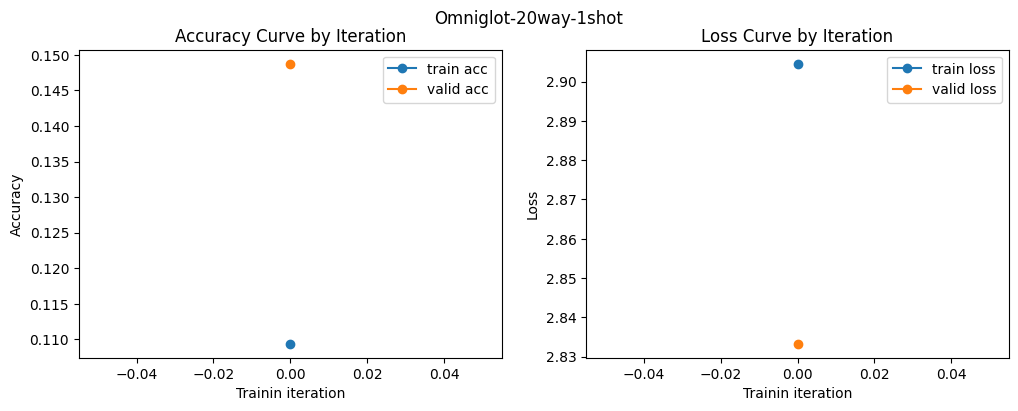

Validation accuracy improved (0.00% --> 14.88%).
Validation accuracy improved (14.88% --> 16.44%).
Validation accuracy improved (16.44% --> 17.37%).
Validation accuracy improved (17.37% --> 20.94%).
Validation accuracy improved (20.94% --> 21.72%).
Validation accuracy improved (21.72% --> 23.44%).
Validation accuracy improved (23.44% --> 25.87%).
Validation accuracy improved (25.87% --> 25.94%).
Validation accuracy improved (25.94% --> 28.25%).
Validation accuracy improved (28.25% --> 28.47%).
Validation accuracy improved (28.47% --> 30.34%).
Validation accuracy improved (30.34% --> 32.22%).
Validation accuracy improved (32.22% --> 32.84%).
Validation accuracy improved (32.84% --> 34.25%).
Validation accuracy improved (34.25% --> 36.31%).
Validation accuracy improved (36.31% --> 37.75%).
Validation accuracy improved (37.75% --> 38.91%).
Validation accuracy improved (38.91% --> 41.81%).
Validation accuracy improved (41.81% --> 42.31%).
Validation accuracy improved (42.31% --> 42.69%).
V

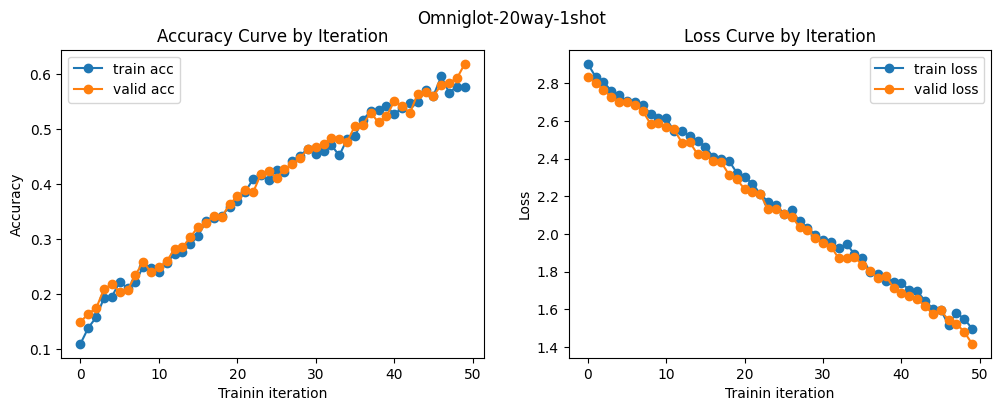

Validation accuracy improved (59.25% --> 61.91%).
Validation accuracy improved (61.91% --> 62.44%).
Validation accuracy improved (62.44% --> 64.03%).
Validation accuracy improved (64.03% --> 64.19%).
Validation accuracy improved (64.19% --> 65.81%).
Validation accuracy improved (65.81% --> 66.19%).
Validation accuracy improved (66.19% --> 67.25%).
Validation accuracy improved (67.25% --> 67.56%).
Validation accuracy improved (67.56% --> 67.97%).
Validation accuracy improved (67.97% --> 68.47%).
Validation accuracy improved (68.47% --> 68.78%).
Validation accuracy improved (68.78% --> 69.66%).
Validation accuracy improved (69.66% --> 69.78%).
Validation accuracy improved (69.78% --> 70.59%).
Validation accuracy improved (70.59% --> 70.97%).
Validation accuracy improved (70.97% --> 71.25%).
Validation accuracy improved (71.25% --> 74.62%).
Validation accuracy improved (74.62% --> 75.34%).
Validation accuracy improved (75.34% --> 75.44%).
Validation accuracy improved (75.44% --> 75.91%).


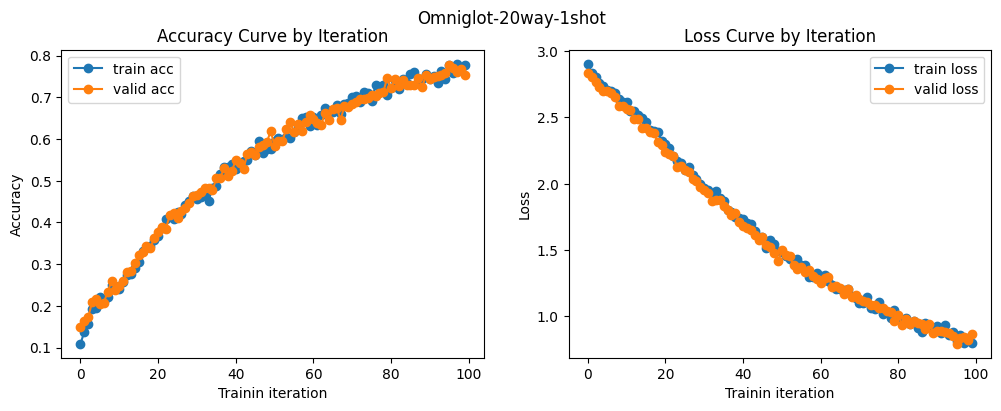

Validation accuracy improved (77.87% --> 78.06%).
Validation accuracy improved (78.06% --> 78.84%).
Validation accuracy improved (78.84% --> 79.37%).
Validation accuracy improved (79.37% --> 79.41%).
Validation accuracy improved (79.41% --> 80.03%).
Validation accuracy improved (80.03% --> 80.37%).
Validation accuracy improved (80.37% --> 82.03%).
Validation accuracy improved (82.03% --> 82.12%).
Validation accuracy improved (82.12% --> 82.94%).
Validation accuracy improved (82.94% --> 83.16%).
Validation accuracy improved (83.16% --> 83.62%).
Validation accuracy improved (83.62% --> 83.72%).
======================== Iteration: 150 ========================
Meta Train Loss: 0.567, Meta Train Acc: 82.78%
Meta Valid Loss: 0.533, Meta Valid Acc: 84.75%


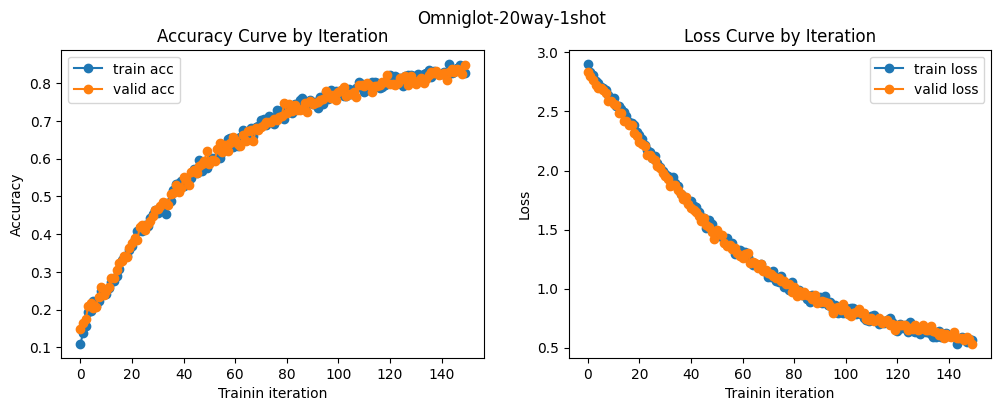

Validation accuracy improved (83.72% --> 84.75%).
Validation accuracy improved (84.75% --> 85.28%).
Validation accuracy improved (85.28% --> 85.44%).
Validation accuracy improved (85.44% --> 85.56%).
Validation accuracy improved (85.56% --> 86.47%).
Validation accuracy improved (86.47% --> 87.28%).
Validation accuracy improved (87.28% --> 87.37%).
Validation accuracy improved (87.37% --> 87.47%).
Validation accuracy improved (87.47% --> 88.16%).
Validation accuracy improved (88.16% --> 88.75%).
======================== Iteration: 200 ========================
Meta Train Loss: 0.392, Meta Train Acc: 88.50%
Meta Valid Loss: 0.423, Meta Valid Acc: 87.03%


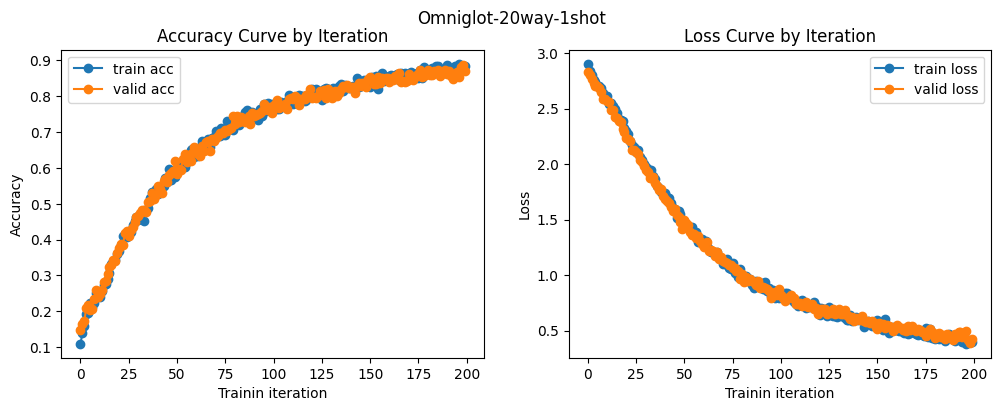

Validation accuracy improved (88.75% --> 88.84%).
Validation accuracy improved (88.84% --> 89.34%).
Validation accuracy improved (89.34% --> 89.94%).
Validation accuracy improved (89.94% --> 90.34%).
Validation accuracy improved (90.34% --> 90.47%).
======================== Iteration: 250 ========================
Meta Train Loss: 0.313, Meta Train Acc: 90.56%
Meta Valid Loss: 0.349, Meta Valid Acc: 89.97%


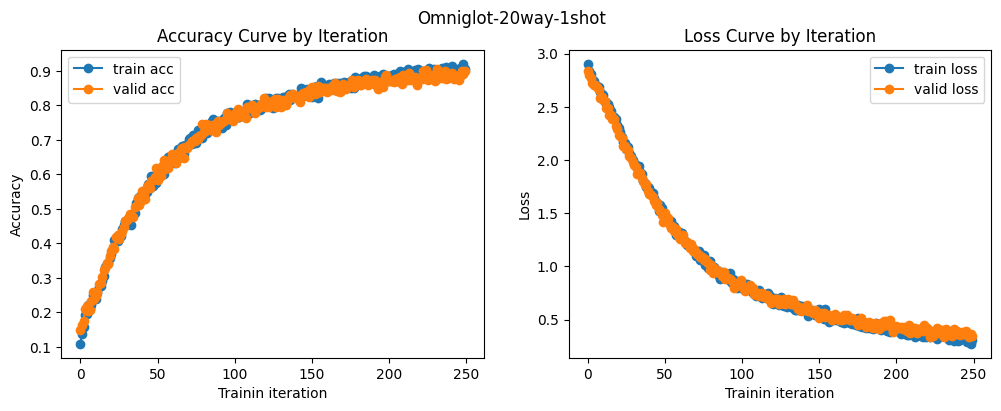

In [21]:
valid_best_acc = 0
train_acc = []
valid_acc = []
train_loss = []
valid_loss = []

train_iter = iter(train_loader)
valid_iter = iter(valid_loader)

for iteration in range(1, num_iterations+1):

    # ========================= train model =====================
    model.train()
    try:
        support_images, support_labels, query_images, query_labels = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        support_images, support_labels, query_images, query_labels = next(train_iter)

    # Get support set and query set data for one meta-batch (several tasks)
    support_images = support_images.float().to(device)
    support_labels = support_labels.long().to(device)
    query_images = query_images.float().to(device)
    query_labels = query_labels.long().to(device)

    # Train init-paras on one meta-batch and get the corresponding 
    # average evaluation (query) loss and acc among these training tasks
    loss, acc = maml_train(model, 
                            support_images, 
                            support_labels, 
                            query_images, 
                            query_labels,
                            train_inner_step, 
                            inner_lr,
                            optimizer, 
                            loss_fn, 
                            is_train=True)
    
    train_loss.append(loss.item())
    train_acc.append(acc)

    if iteration == 1 or iteration % display_gap == 0:
        print('======================== Iteration: {} ========================'.format(iteration))
        print('Meta Train Loss: {:.3f}, Meta Train Acc: {:.2f}%'.format(loss, 100 * acc))
    
    # ====================== validate model ====================
    model.eval()
    try:
        support_images, support_labels, query_images, query_labels = next(valid_iter)
    except StopIteration:
        valid_iter = iter(valid_loader)
        support_images, support_labels, query_images, query_labels = next(valid_iter)
    
    support_images = support_images.float().to(device)
    support_labels = support_labels.long().to(device)
    query_images = query_images.float().to(device)
    query_labels = query_labels.long().to(device)

    loss, acc = maml_train(model, 
                            support_images, 
                            support_labels, 
                            query_images, 
                            query_labels,
                            train_inner_step, 
                            inner_lr,
                            optimizer, 
                            loss_fn, 
                            is_train=False)

    valid_loss.append(loss.item())
    valid_acc.append(acc)

    if iteration == 1 or iteration % display_gap == 0:
        print('Meta Valid Loss: {:.3f}, Meta Valid Acc: {:.2f}%'.format(loss, 100 * acc))
        print('=============================================================='.format(iteration))

        # ========================= plot ==========================
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plt.plot(train_acc, '-o', label="train acc")
        plt.plot(valid_acc, '-o', label="valid acc")
        plt.xlabel('Trainin iteration')
        plt.ylabel('Accuracy')
        plt.title("Accuracy Curve by Iteration")
        plt.legend()
        plt.subplot(122)
        plt.plot(train_loss, '-o', label="train loss")
        plt.plot(valid_loss, '-o', label="valid loss")
        plt.xlabel('Trainin iteration')
        plt.ylabel('Loss')
        plt.title("Loss Curve by Iteration")
        plt.legend()
        plt.suptitle("Omniglot-{}way-{}shot".format(n_way, k_shot))
        plt.show()

    # ========================= save model =====================
    if np.mean(acc) > valid_best_acc:
        print('Validation accuracy improved ({:.2f}% --> {:.2f}%).'.format(100 * valid_best_acc, 100 * acc))
        valid_best_acc = np.mean(acc)
        torch.save(model.state_dict(), 'maml-para.pt')

In [22]:
# ====================== evaluate model ====================
model.load_state_dict(torch.load('maml-para.pt'))
test_acc = []
test_loss = []

test_bar = tqdm(test_loader)
model.eval()
for support_images, support_labels, query_images, query_labels in test_bar:
    test_bar.set_description("Testing")

    support_images = support_images.float().to(device)
    support_labels = support_labels.long().to(device)
    query_images = query_images.float().to(device)
    query_labels = query_labels.long().to(device)

    loss, acc = maml_train(model, 
                    support_images, 
                    support_labels, 
                    query_images, 
                    query_labels,
                    eval_inner_step, 
                    inner_lr,
                    optimizer, 
                    loss_fn, 
                    is_train=False)
    test_loss.append(loss.item())
    test_acc.append(acc)

test_loss = np.mean(test_loss)
test_acc = np.mean(test_acc)
print('Meta Test Loss: {:.3f}, Meta Test Acc: {:.2f}%'.format(test_loss, 100 * test_acc))

/tmp/ipykernel_23/1254240370.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('maml-para.pt'))
Testing: 100%|██████████| 20/20 [02:18<00:

Meta Test Loss: 0.549, Meta Test Acc: 83.47%


In [23]:
model_save_path = "maml_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to maml_model.pth
